In [1]:
# for parsing xml file
from lxml import etree

# for polygon geometries
from shapely.geometry import Polygon
import geopandas as gpd

# for visualizing geometries and DEM
import matplotlib.pyplot as plt

# for reading & processing DEM file
import json
import rasterio
from rasterio.mask import mask

In [2]:
# parse KML
tree = etree.parse('data/polygons/RegressionRidge_smol.kml')
ns = {'kml': 'http://www.opengis.net/kml/2.2'}

# find all polygons
polygons = tree.xpath('//kml:Polygon', namespaces=ns)

# list to hold polygons
geoms = []

# iterate over polygons to grab individual plot geometries
for poly in polygons:
    # grab text of individual polygons
    coords_text = poly.xpath('.//kml:coordinates', namespaces=ns)[0].text
    
    # parse string and convert to float
    coords = [(float(x), float(y)) for x,y, *_ in (c.split(',') for c in coords_text.strip().split())]
    geoms.append(Polygon(coords))

# save geometries as a geopandas df
gdf = gpd.GeoDataFrame(geometry=geoms)

# export as geojson
gdf.to_file('data/polygons/RegressionRidge_smol.geojson', driver='GeoJSON')

In [3]:
# read the geojson to a df

vineyard = gpd.read_file('data/polygons/RegressionRidge.geojson')

plots = gpd.read_file('data/polygons/RegressionRidge_smol.geojson')

Now let's load the dem. The file is downloaded from USGS, I think. DEMs can be found anywhere if you look hard enough

In [4]:
nodata_val = -9999

# capture vineyard outline geometry
geoms = [json.loads(vineyard.to_json())['features'][0]['geometry']]

# set path for dem
dem_path = 'data/DEM/USGS_1M_11_x28y509_WA_ColumbiaValley_2018_D19_4326.tif' 

# open dem.tif and clip according to vineyard geometry
with rasterio.open(dem_path) as src:
    # DEM metadata
    print('CRS:', src.crs)
    print('Bounds:', src.bounds)
    print('Resolution:', src.res)
    print('Min/Max:', src.read(1).min(), src.read(1).max())
    
    # mask and clip the DEM to the vineyard outline
    dem_clip, dem_transform = mask(src, geoms, crop=True, filled=True, nodata=nodata_val)
    dem_clip = dem_clip.astype('float32')  # convert to float
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]  # xmin, xmax, ymin, ymax
    crs = src.crs
    dem_meta = src.meta.copy()
    dem_meta.update({
        'driver': 'GTiff',
        'height': dem_clip.shape[1],
        'width': dem_clip.shape[2],
        'transform': dem_transform,
        'dtype': 'float32',
        'nodata':nodata_val
    })
    

# save the clipped DEM
with rasterio.open('data/DEM/RegressionRidge_DEM.tif', 'w', **dem_meta) as dest:
    dest.write(dem_clip)
    
    

CRS: EPSG:4326
Bounds: BoundingBox(left=-119.83764590773423, bottom=45.83838088032461, right=-119.70428163309667, top=45.931513299017475)
Resolution: (1.124108855677316e-05, 1.124108855677316e-05)
Min/Max: -999999.0 291.0126


In [5]:
dem_clip

array([[[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        ...,
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.]]],
      dtype=float32)

Nice, now we have a DEM clipped to the outline. Now let's visualize it with the smaller plot polygons.

First we have to do some projection book-keeping to make sure everything is aligned.

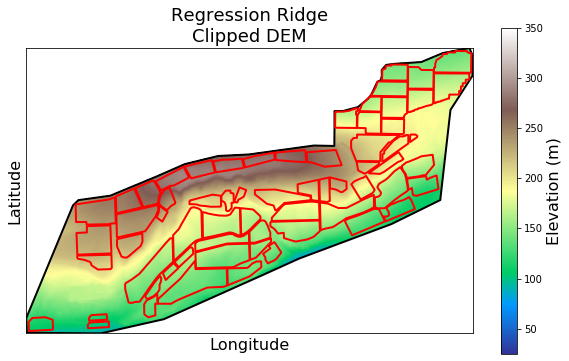

In [15]:
with rasterio.open('data/DEM/RegressionRidge_DEM.tif') as src:
    dem = src.read(1, masked=True)  # auto-masks nodata values
    raster_crs = src.crs
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

fig, ax = plt.subplots(figsize=(10, 6))

# Plot DEM
im = ax.imshow(
    dem,
    extent=extent,
    origin='upper',
    cmap='terrain',
    vmin=25,
    vmax=350
)

# Add colorbar and set label/fontsize
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Elevation (m)', fontsize=16)

# Titles and axis labels
plt.title('Regression Ridge\nClipped DEM', fontsize=18)
plt.xlabel('Longitude', fontsize=16)
plt.ylabel('Latitude', fontsize=16)

# Hide ticks
plt.xticks([])
plt.yticks([])

# Overlay vineyard and subplots
vineyard.plot(ax=ax, facecolor='none', edgecolor='k', linewidth=2)
plots.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2, label='Subplots')


plt.savefig('img/dem_clip.png')